
#Installation
---



In [57]:
from pathlib import Path
import os
from datetime import date
import re
import glob
from tqdm.notebook import tqdm

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box
import dask.dataframe as dd
pd.options.mode.chained_assignment = None

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [29]:
# Paths
p = Path('/Users/alex/Dropbox/Work/GNS/008_FFE/ProbaFFE/FFE')
pathShapefile = p / 'shapefile'
pathParquets = p / 'output'

print(len(os.listdir(pathParquets)))
print(os.listdir(pathShapefile))

2999
['ExcLosses.png', 'CountBurn-2020-08-06.parquet', 'WellWHV_Buildings.dbf', 'BurnscenarioWellington.dbf', 'CountBurn-2020-08-07.parquet', 'BurnscenarioWellington.mshp', 'Finn_MeshBlockSummary.qpj', 'DsitributionLosses.png', 'CountBurn-2020-08-05.parquet', 'WellWHV_Buildings.sbx', 'CountBurn-2020-08-04.parquet', 'BurnscenarioWellington.shx', 'Finn_MeshBlockSummary.prj', 'WellWHV_Buildings.shx', 'BurnscenarioWellington.cpg', 'BurnscenarioWellington.shp', 'WellWHV_Buildings.shp', 'WellWHV_Buildings.cpg', 'Burn3000scenarioWellington.sprj', 'ComparisonGISvsNetwork_3000Burn.png', 'Finn_MeshBlockSummary.dbf', 'WellWHV_Buildings.sbn', 'Finn_MeshBlockSummary.shp', 'Finn_MeshBlockSummary.cpg', 'BurnscenarioWellington.prj', 'CountBurn-2020-08-13.parquet', 'Finn_MeshBlockSummary.shx', 'WellWHV_Buildings.prj']


In [9]:
def read_and_concatenate_parquets(path=pathParquets):
    L = []
    files = pathParquets.glob('*scenario*')
    for file in files:
#         print(f'{file} loaded file \n {len(L)}/2999')
        pqt = dd.read_parquet(file, engine='auto')
        L.append(pqt)
    df = dd.concat(L)
    return df

    
def count_fid_occurences(df): 
    count_df = df['source'].value_counts().compute()
    count_df = pd.DataFrame({'FID': count_df.index, 'count': count_df.values})
    count_df.to_parquet(str(pathShapefile) + '/' + f'CountBurn-{str(date.today())}.parquet', 
                        engine='auto', compression="GZIP")# could be datetime.now
    return count_df


def Merge(countDf,nameShapefile):
    gdfShape = gpd.read_file(pathShapefile / nameShapefile)
    gdfShape.insert(0, 'FID', range(0, len(gdfShape)))
#     m = pd.merge(countConcatDf,gdfShape, how='left',on='FID')
    merged = countDf.merge(gdfShape, on=['FID'], how='left')
    return merged


def createShapefile(df):
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.to_file(os.path.join(str(pathShapefile) + "/" + "BurnscenarioWellington.shp"))
    return gdf

**Create count files**

In [10]:
%%time
concatDf = read_and_concatenate_parquets()

countConcatDf = count_fid_occurences(concatDf)

mergedDf = Merge(countConcatDf, 'WellWHV_Buildings.shp')
countShape = createShapefile(mergedDf)

CPU times: user 2min 23s, sys: 17.3 s, total: 2min 40s
Wall time: 45min 43s


**Plot Burn Map**

In [83]:
import contextily as ctx

Text(0.5, 1, 'Finn burn count at meshblock level')

Text(0.5, 1, 'Burn count at individual building level')

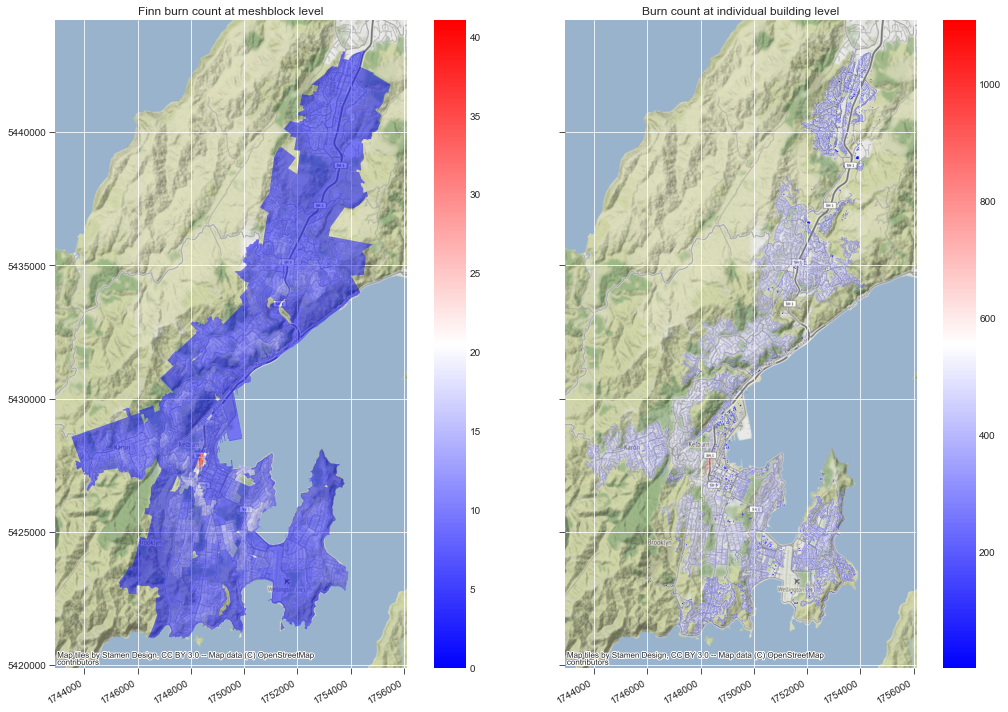

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-darkgrid')

FinnMeshblockShape = gpd.read_file(pathShapefile / 'Finn_MeshBlockSummary.shp')
# countShape = gpd.read_file(pathShapefile / 'Burn3000scenarioWellington.shp')

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 10))

FinnMeshblockShape.plot(ax=ax1, column='WellWHV_Bu', cmap='bwr', alpha=0.5, legend=True)
ctx.add_basemap(ax1, crs=2193)
countShape.plot(ax=ax2, column='count', cmap='bwr', alpha=0.9, legend=True)
ctx.add_basemap(ax2, crs=2193)

ax1.set_title('Finn burn count at meshblock level')
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.tick_params(direction='out', length=6)
ax2.set_title('Burn count at individual building level')
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.tick_params(direction="out", length=6)

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(pathShapefile / 'ComparisonGISvsNetwork_3000Burn.png', dpi=600)
plt.show()

**Plot distributions**

Text(0.5, 1.0, 'Distribution of fires')

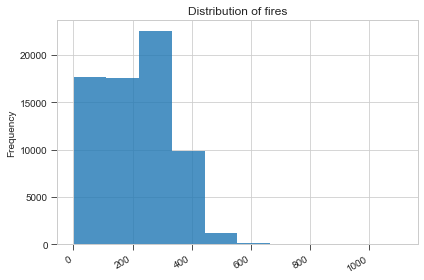

In [13]:
plt.style.use('seaborn-whitegrid')
fig, (ax1) = plt.subplots(nrows=1, ncols=1)#, figsize=(15, 10))

countConcatDf['count'].plot(kind='hist', ax=ax1, alpha=0.8)

ax1.set_title('Distribution of fires')
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.tick_params(direction="out", length=6)

fig.autofmt_xdate()
plt.tight_layout()
# plt.savefig(pathShapefile / 'ComparisonGISvsNetwork_3000Burn.png', dpi=600)
plt.show()

(array([ 19., 145., 480., 704., 776., 494., 254.,  82.,  36.,   9.]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, 'Distribution of ignitions')

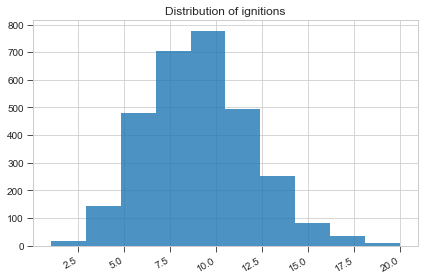

In [22]:
c = concatDf.drop_duplicates('scenario').compute()

plt.style.use('seaborn-whitegrid')
fig, (ax1) = plt.subplots(nrows=1, ncols=1)#, figsize=(15, 10))

ax1.hist(c['InitialIgnitions'], alpha=0.8)
# sns.distplot(c['InitialIgnitions'], ax=ax1)
# c['InitialIgnitions'].plot('hist', ax=ax1, alpha=0.8)

ax1.set_title('Distribution of ignitions')
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.tick_params(direction="out", length=6)

fig.autofmt_xdate()
plt.tight_layout()
# plt.savefig(pathShapefile / 'ComparisonGISvsNetwork_3000Burn.png', dpi=600)
plt.show()

**Loss calculation**

In [42]:
costDataShape = gpd.read_file(pathShapefile / 'WellWHV_Buildings.shp')
costDataShape.columns

Index(['Replacemen', 'Combustibl', 'FloorArea', 'BLDG_ID', 'SA2_ID',
       'NightOccup', 'IgnProbBld', 'geometry'],
      dtype='object')

In [70]:
from dask.diagnostics import ProgressBar

# ccDf = concatDf[['source', 'scenario']].compute() 
costDataShape = gpd.read_file(pathShapefile / 'WellWHV_Buildings.shp')
costData = pd.DataFrame(costDataShape)
costData.drop(['Combustibl', 'FloorArea', 'BLDG_ID', 'SA2_ID','NightOccup','geometry'], axis=1, inplace=True)
# merge
ccDfLoss = dd.merge(concatDf, costData, how='left', left_on='source', right_index=True) # would need to work with Dask !!
ccDfLossCum = ccDfLoss.groupby(['scenario'])['Replacemen'].sum().reset_index()
# print(type(ccDfLoss), type(ccDfLossCum))

pbar = ProgressBar()
pbar.register()

lossCum = ccDfLossCum.compute()
print(f"the worst scenario is : \n {lossCum[lossCum['Replacemen'] == max(lossCum['Replacemen'])]}")

[########################################] | 100% Completed |  2min 35.1s
[########################################] | 100% Completed |  2min 35.1s
[########################################] | 100% Completed |  2min 35.2s
[########################################] | 100% Completed |  2min 35.3s
[########################################] | 100% Completed |  2min 35.4s
[########################################] | 100% Completed |  2min 35.3s
the worst scenario is : 
       scenario    Replacemen
1673      1465  2.178725e+10


In [66]:
# FinnLossesReport = np.array([0, 125000000, 263888888.9, 680555555.6, 1062500000, 1340277778, 2000000000, 
#               2555555556, 2972222222, 5020833333, 5402777778, 5854166667, 6305555556, 6444444444,
#               6965277778, 7243055556, 7381944444, 7902777778, 8145833333, 10263888889, 12347222222, 
#               13215277778, 14152777778])

# FinnProbabilityReport = np.array([0, 0.507380074, 0.556457565, 0.566789668, 0.584870849, 0.605535055, 
#                    0.719188192, 0.763099631, 0.770848708, 0.773431734, 0.804428044, 0.845756458,
#                    0.871586716, 0.871586716, 0.918081181, 0.923247232, 0.938745387, 0.949077491, 
#                    0.959409594, 0.972324723, 0.982656827, 0.985239852, 0.990405904])

pathFinn = Path('/Users/alex/Dropbox/Work/GNS/008_FFE/ProbaFFE/OutputFinn')
dataFinn3000 = pd.read_csv(pathFinn / 'ScenSumWellWHV_pfour_1-3000.csv')

lossLevels = np.arange(1000, 100e9, 10000)
excMoreFinn = np.array([np.count_nonzero(dataFinn3000.ReplacementValue.values >= x) for x in lossLevels])/3000

In [67]:
max(dataFinn3000.ReplacementValue)/1e9
max(ccDflossCum.Replacemen)/1e9

7.114701276

21.787246149

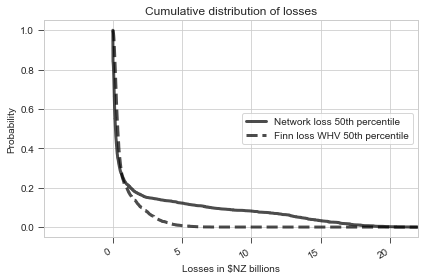

CPU times: user 3min 11s, sys: 5.92 s, total: 3min 17s
Wall time: 4min 25s


In [68]:
%%time
lossLevels = np.arange(1000, 100e9, 10000)
# excLess = np.array([np.count_nonzero(ccDflossCum.Replacemen.values <= x) for x in lossLevels])/3000
excMore = np.array([np.count_nonzero(lossCum.Replacemen.values >= x) for x in lossLevels])/3000


plt.style.use('seaborn-whitegrid')
fig, (ax1) = plt.subplots(nrows=1, ncols=1)#, figsize=(15, 10))

# ax1.plot(lossLevels/1e9, excLess, linewidth=2, linestyle='label='loss inferior')
ax1.plot(lossLevels/1e9, excMore, linewidth=3, linestyle='solid', alpha=0.7, color='black', label='Network loss 50th percentile')
# ax1.plot(FinnLosses/1e9, FinnProbability, linewidth=2, linestyle='dashed', label='Finn loss report')
ax1.plot(lossLevels/1e9, excMoreFinn, linewidth=3, linestyle='dashed', alpha=0.7, color='black', label='Finn loss WHV 50th percentile')

ax1.set_title('Cumulative distribution of losses')
ax1.ticklabel_format(useOffset=False, style= 'scientific')
ax1.tick_params(direction="out", length=6)
ax1.legend(loc="center right", frameon=True)
ax1.set(xlabel="Losses in $NZ billions", ylabel="Probability")
# ax1.set_xscale('log')
ax1.set_xlim([None, 22])

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(pathShapefile / 'ExcLosses.png', dpi=600)
plt.show()


(array([158.,  63.,  34.,  35.,  35.,  31.,  24.,  19.,  12.,  21.,  22.,
         35.,  33.,  35.,  25.,  22.,  25.,  13.,   8.,   3.,   2.,   0.,
          0.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]),
 <a list of 1 Patch objects>)

(array([292., 156.,  88.,  42.,  16.,   3.,   3.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]),
 <a list of 23 Patch objects>)

Text(0.5, 1.0, 'Distribution of losses')

Text(0.5, 0, 'Loss billions $NZ')

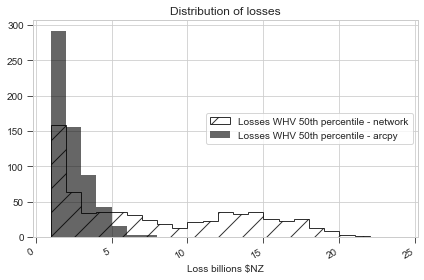

In [72]:
plt.style.use('seaborn-whitegrid')
fig, (ax1) = plt.subplots(nrows=1, ncols=1)#, figsize=(15, 10))

billionLossAlex = lossCum.Replacemen / 1e9
billionLossFinn = dataFinn3000.ReplacementValue / 1e9

# ccDflossCum.Replacemen.plot('hist', alpha=0.8)
ax1.hist(billionLossAlex, bins=np.arange(1,25), fill=False, histtype='step', hatch='/', color='black', alpha=0.8, label='Losses WHV 50th percentile - network')
ax1.hist(billionLossFinn, bins=np.arange(1,25), fill=True, color='black', alpha=0.6, label='Losses WHV 50th percentile - arcpy')

ax1.set_title('Distribution of losses')
ax1.ticklabel_format(useOffset=False, style= 'scientific')
ax1.tick_params(direction="out", length=6)
# ax1.set_yscale('log')
ax1.set_xlabel('Loss billions $NZ')
ax1.legend(loc="center right", frameon=True)

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(pathShapefile / 'DistributionLosses.png', dpi=600)
plt.show()

**Create Gif for largest scenario**

In [81]:
# keep only the ignition steps for the worst scenario
worstScenario = concatDf[concatDf['scenario']== 1465]
pbar = ProgressBar()
pbar.register()
worstScenario = worstScenario.compute()

# merge each line / source with geometry 
shape = gpd.read_file(pathShapefile / 'WellWHV_Buildings.shp')
shape.drop(['Combustibl', 'FloorArea', 'BLDG_ID', 'NightOccup'], axis=1, inplace=True)
worstScenario = pd.merge(worstScenario, shape, how='left', left_on='source', right_index=True)

[########################################] | 100% Completed |  2min 19.9s
[########################################] | 100% Completed |  2min 20.0s
[########################################] | 100% Completed |  2min 20.0s
[########################################] | 100% Completed |  2min 20.1s
[########################################] | 100% Completed |  2min 20.1s
[########################################] | 100% Completed |  2min 20.1s
[########################################] | 100% Completed |  2min 20.2s
[########################################] | 100% Completed |  2min 20.2s
[########################################] | 100% Completed |  2min 20.1s


In [82]:
worstScenario

source  target   distance     bearing  IgnProbBld_x  time  scenario  \
44070      1004    2201   2.913668   13.115710      0.000071     0      1465   
192468     4431    1921  65.213488  359.454090      0.000213     0      1465   
260918     5990     448  61.642577  216.642697      0.000068     0      1465   
405417     9372     401  84.968833  188.388735      0.000092     0      1465   
456908    10576    1709  58.543074  287.677992      0.000102     0      1465   
...         ...     ...        ...         ...           ...   ...       ...   
2681027   62250    2997  26.630435   62.361472      0.000081   144      1465   
2803504   65067     292  31.861646  108.869981      0.000081   144      1465   
515518    11943    2997  22.817604  145.148564      0.000081   145      1465   
889500    20630     292  34.915445  194.294096      0.000081   145      1465   
2195757   50919   20630   5.664797  202.494365      0.000081   145      1465   

         InitialIgnitions  Replacemen  SA2_ID  IgnProbBld_y  \
44070                  16    250272.0      59      0.000071   
192468                 16    721143.0      58      0.000213   
260918                 16     29546.0      69      0.000068   
405417                 16     31736.0      25      0.000092   
456908                 16    569178.0      38      0.000102   
...                   ...         ...     ...           ...   
2681027                16    437976.0      60      0.000081   
2803504                16    161634.0      60      0.000081   
515518                 16    225940.0      60      0.000081   
889500                 16    206822.0      60      0.000081   
2195757                16    213774.0      60      0.000081   

                                                  geometry  
44070    POLYGON ((1747443.628 5421513.826, 1747440.570...  
192468   POLYGON ((1750680.175 5427474.457, 1750695.134...  
260918   POLYGON ((1750231.002 5423363.634, 1750231.215...  
405417   POLYGON ((1750959.507 5434863.390, 1750963.246...  
456908   POLYGON ((1750932.017 5432789.137, 1750927.978...  
...                                                    ...  
2681027  POLYGON ((1747617.673 5423370.700, 1747626.001...  
2803504  POLYGON ((1747581.526 5423337.323, 1747587.724...  
515518   POLYGON ((1747606.194 5423322.046, 1747615.743...  
889500   POLYGON ((1747533.296 5423303.926, 1747539.546...  
2195757  POLYGON ((1747525.636 5423287.591, 1747532.825...  

[60842 rows x 12 columns]

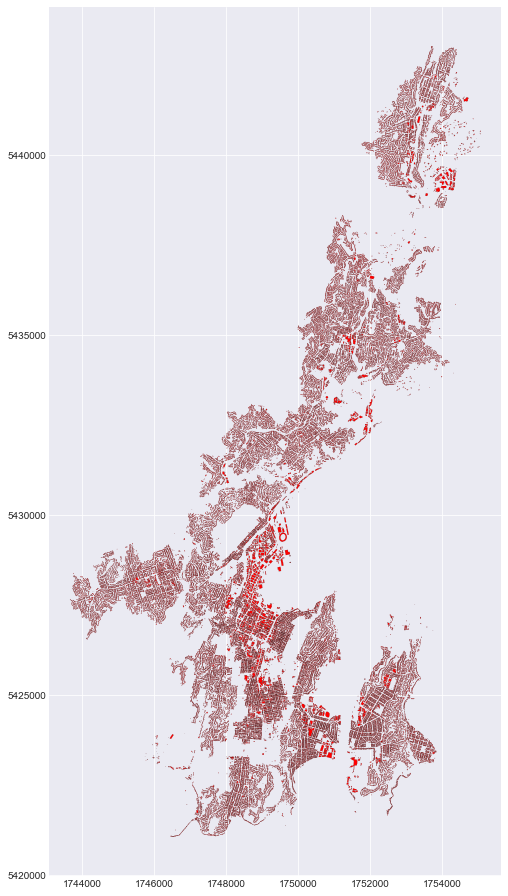

In [133]:
mapShape = gpd.read_file(pathShapefile / 'WellWHV_Buildings.shp')
fig, ax = plt.subplots(figsize = (20,16)) 
mapShape.plot(color='red',edgecolor=None, ax=ax)
mapShape.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.1, ax=ax)

plt.show()

In [136]:
def save_png(df, path):
    gdf = gpd.GeoDataFrame(df, geometry=df.geometry)
    mapShape = gpd.read_file(path / 'WellWHV_Buildings.shp')
    for t in tqdm(range(max(gdf.time))):
        gdfT = gdf[gdf.time==t]
        # plot
        fig, ax = plt.subplots(figsize = (20,16)) 
        gdfT.plot(color="red", edgecolor=None, ax=ax)
        mapShape.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.1,ax=ax)
        # savefig
        plt.savefig(os.path.join(str(pathShapefile), 'gif', f'time{t}.png'), dpi=600)
        plt.close()
        
def create_gif():
    import glob
    from PIL import Image
    # filepaths
    fp_in = "/Users/alex/Dropbox/Work/GNS/008_FFE/ProbaFFE/FFE/shapefile/gif/time*.png"
    fp_out = "/Users/alex/Dropbox/Work/GNS/008_FFE/ProbaFFE/FFE/shapefile/worseScenario.gif"
    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)
    im = Image.open(fp_out)
    return im

In [137]:
save_png(worstScenario, path=pathShapefile)

In [1]:
gif = create_gif()

NameError: name 'create_gif' is not defined

In [ ]:
gif